In [62]:
import pandas as pd
import matplotlib.pyplot as plt 

aviation_file = "NTSBAviationData.csv"

df = pd.read_csv(aviation_file, encoding="latin1")

/var/folders/7l/h7qnw85j2hlf4tgr241lw5f00000gn/T/ipykernel_48386/972293648.py:6: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(aviation_file, encoding="latin1")


In [63]:
date_cols = ["Event.Date", "Publication.Date"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col],errors="coerce")

categorical_cols = [
    "Investigation.Type", "Injury.Severity", "Aircraft.damage",
    "Aircraft.Category", "Amateur.Built", "Engine.Type",
    "FAR.Description", "Schedule", "Purpose.of.flight",
    "Weather.Condition", "Broad.phase.of.flight", "Report.Status"
]
for col in categorical_cols:
    df[col] = df[col].astype("category")

/var/folders/7l/h7qnw85j2hlf4tgr241lw5f00000gn/T/ipykernel_48386/3811385984.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col],errors="coerce")


In [64]:
import pandas as pd
import matplotlib.pyplot as plt

def line_chart(df, date_col, group_col, years=None, title=None):
    """plots counts per year for categories in group_col for 
    given num of years"""
    df = df.copy()
    # restrict to last n years 
    if years is not None:
        max_date = df[date_col].max()
        cutoff = max_date - pd.DateOffset(years=years)
        df = df[df[date_col] >= cutoff]

    # extract year
    df["Year"] = df[date_col].dt.year

    # group by year + category
    counts = (
        df.groupby(["Year", group_col])
        .size()
        .reset_index(name="Count")
        .pivot(index="Year", columns=group_col, values="Count")
        .fillna(0)
    )

    # plotting
    ax = counts.plot(kind="line", marker="o")
    if not title:
        title = f"{group_col} counts"
        if years:
            title += f" (last {years} years)"
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.set_xlabel("Year")
    ax.legend(title=group_col)
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.show()

/var/folders/7l/h7qnw85j2hlf4tgr241lw5f00000gn/T/ipykernel_48386/2800345279.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Year", group_col])


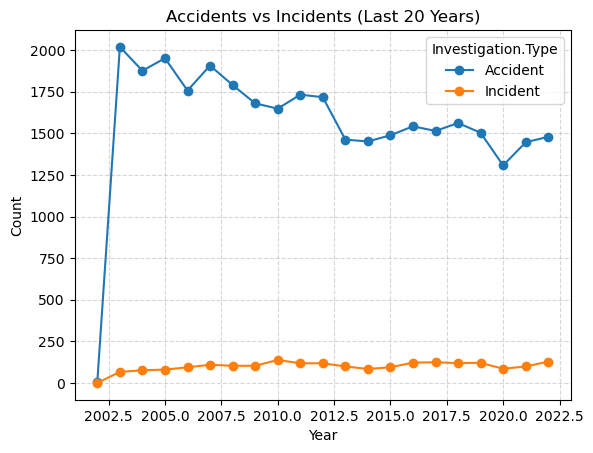

In [65]:
# line chart
line_chart(df, "Event.Date", "Investigation.Type", years=20,
           title="Accidents vs Incidents (Last 20 Years)")

In [66]:
print(df.isna().sum())

Event.Id                      0
Investigation.Type            0
Accident.Number               0
Event.Date                    0
Location                     52
Country                     226
Latitude                  54507
Longitude                 54516
Airport.Code              38757
Airport.Name              36185
Injury.Severity            1000
Aircraft.damage            3194
Aircraft.Category         56602
Registration.Number        1382
Make                         63
Model                        92
Amateur.Built               102
Number.of.Engines          6084
Engine.Type                7096
FAR.Description           56866
Schedule                  76307
Purpose.of.flight          6192
Air.carrier               72241
Total.Fatal.Injuries      11401
Total.Serious.Injuries    12510
Total.Minor.Injuries      11933
Total.Uninjured            5912
Weather.Condition          4492
Broad.phase.of.flight     27165
Report.Status              6384
Publication.Date          13771
dtype: i

In [67]:
# proportion chart 
def proportion_chart(df, date_col, group_col, title=None):
    """Makes a proportion chart of fatal vs non-fatal events over time"""
    # some cleaning for all the na's: classify fatal vs non-fatal
    df["FatalEvent"] = df[group_col].fillna(0).apply(lambda x: "Fatal" if x > 0 else "Non-Fatal")

    # group by year + fatal flag
    df["Year"] = df[date_col].dt.year.astype(int)
    counts = (
        df.groupby(["Year", "FatalEvent"])
        .size()
        .reset_index(name="Count")
        .pivot(index="Year", columns="FatalEvent", values="Count")
        .fillna(0)
    )

    # proportions
    proportions = counts.div(counts.sum(axis=1), axis=0)

    # plot as stacked area
    ax = proportions.plot(kind="area", stacked=True, alpha=0.6, figsize=(8,5))
    if not title:
        title = "Proportion of Fatal vs Non-Fatal Events"
    ax.set_title(title)
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Year")
    ax.legend(title="Event Type")
    plt.show()

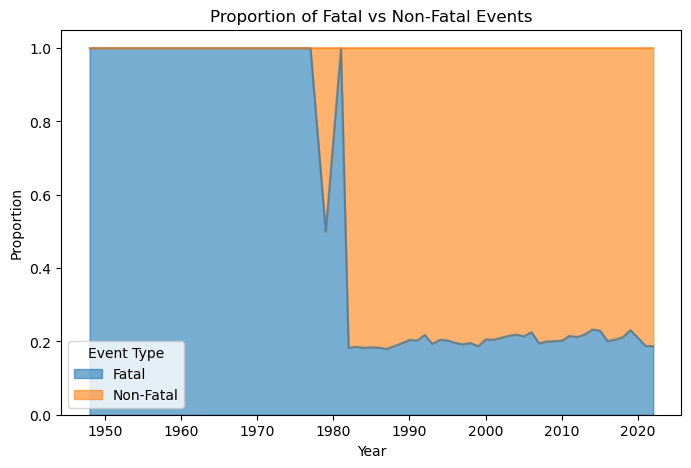

In [68]:
proportion_chart(df, "Event.Date", "Total.Fatal.Injuries",
                 title="Proportion of Fatal vs Non-Fatal Events")

In [69]:
def safety_score(df, date_col, fatal_col):
    """compute safety score for the most recent year: cafety Score = % of non-fatal events"""
    df = df.copy()

    # most recent year in dataset
    latest_year = df[date_col].dt.year.max()
    recent = df[df[date_col].dt.year == latest_year]

    total_events = len(recent)
    non_fatal_events = (recent[fatal_col].fillna(0) == 0).sum()

    score = (non_fatal_events / total_events) * 100 if total_events > 0 else 0
    return latest_year, score


Safety Score for 2022: 81.27


In [ ]:
year, score = safety_score(df, "Event.Date", "Total.Fatal.Injuries")
print(f"Safety Score for {year}: {score:.2f}")

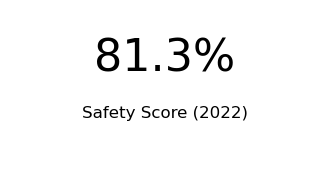

In [70]:
# card 
year, score = safety_score(df, "Event.Date", "Total.Fatal.Injuries")

fig, ax = plt.subplots(figsize=(4,2))
ax.text(0.5, 0.6, f"{score:.1f}%", fontsize=32, ha="center")
ax.text(0.5, 0.3, f"Safety Score ({year})", fontsize=12, ha="center")
ax.axis("off")
plt.show()


In [ ]:
# make dashboard here 